# Задание 1

## Импорт

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Я профи/problem_1"

Mounted at /content/drive
/content/drive/MyDrive/Я профи/problem_1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

%matplotlib inline

In [107]:
train = pd.read_csv('train.csv')
labels = train['Onshore/Offshore']
train.drop('Onshore/Offshore', axis=1, inplace=True)
test = pd.read_csv('test.csv')

In [108]:
print(len(train))
train.head()

309


,Tectonic regime,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0


## Пропуски

In [5]:
# your code here
print('В данных есть пропуски? - %s' % str(train.isnull().any().any()))
print('Пропуски обнаружены в слудующих столбцах: ')
miss = train.isnull().any()[train.isnull().any() == True]
print(miss)
print('-'*40)
for i in miss.index:
  print('В столбце %s: %d пропусков, их доля %.2f%%' % (i, sum(train[i].isnull()), float(100 * sum(train[i].isnull())) / len(train)))

В данных есть пропуски? - False
Пропуски обнаружены в слудующих столбцах: 
Series([], dtype: bool)
----------------------------------------


## One-hot

In [109]:
def get_proper_dummies(train, test):
    for col in ['Structural setting', 'Tectonic regime', 'Period']: # train.select_dtypes(include=['object']).columns:
        classes = pd.Series(train[col].unique()).apply(lambda x: re.split('[/-]', x)).tolist()
        classes = np.array([j for i in classes for j in i])
        # print(np.unique(classes))
        for label in np.unique(classes):
            train[col + '_' + label] = train[col].apply(lambda x: int(label in re.split('[/-]', x)))
            test[col + '_' + label] = test[col].apply(lambda x: int(label in re.split('[/-]', x)))
    train.drop(['Period', 'Structural setting_', 'Structural setting', 'Tectonic regime'], axis=1, inplace=True)
    test.drop(['Period', 'Structural setting_', 'Structural setting', 'Tectonic regime'], axis=1, inplace=True)
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)
    return train[set(test.columns) & set(train.columns)], test[set(test.columns) & set(train.columns)] # Мб предсказать 

In [110]:
from sklearn.preprocessing import LabelEncoder

X, X_test = get_proper_dummies(train, test)

enc = LabelEncoder()
y = enc.fit_transform(labels)
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([ 93, 211,   5]))

## Статистики

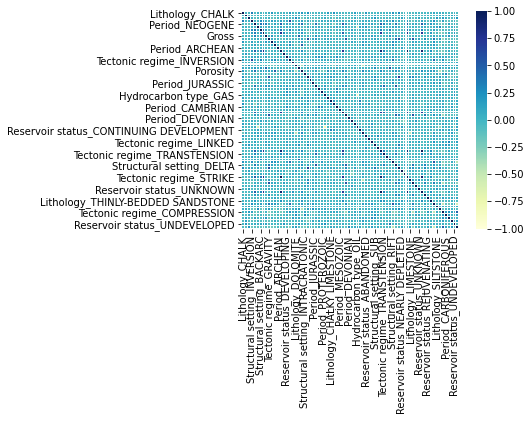

In [111]:
correl = pd.DataFrame(X).corr()
sns.heatmap(correl, vmin = -1, vmax = 1, linewidths = 0.01, square = True, cmap="YlGnBu")
plt.show()

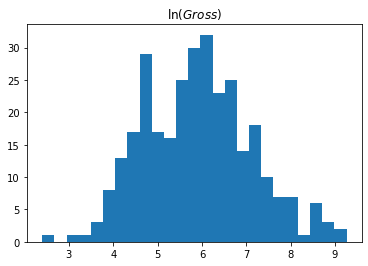

In [9]:
plt.title(u'$\ln (Gross)$')
plt.hist(np.log(train['Gross']), bins = 25)
plt.show()

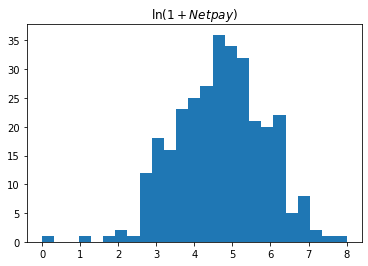

In [10]:
plt.title(u'$\ln (1 + Netpay)$')
plt.hist(np.log1p(train['Netpay']), bins = 25)
plt.show()

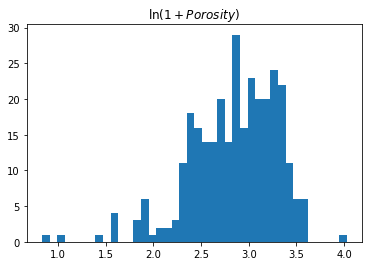

In [139]:
plt.title(u'$\ln (1 + Porosity)$')
plt.hist(np.log1p(train['Porosity']), bins = 40)
plt.show()

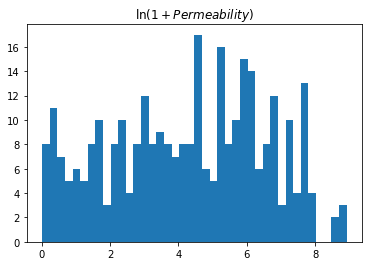

In [137]:
plt.title(u'$\ln (1 + Permeability)$')
plt.hist(np.log1p(train['Permeability']), bins = 40)
plt.show()

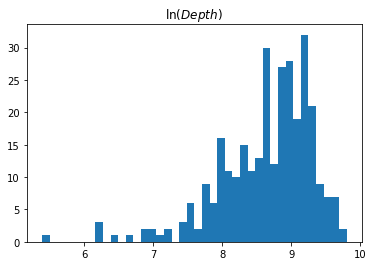

In [136]:
plt.title(u'$\ln (Depth)$')
plt.hist(np.log(train['Depth']), bins = 40)
plt.show()

In [14]:
X['Gross'] = np.log(X['Gross'])
X['Netpay'] = np.log1p(X['Netpay'])
X['Porosity'] = np.log1p(X['Porosity'])
X['Permeability'] = np.log(X['Permeability'])
X['Depth'] = np.log(X['Depth'])

X_test['Gross'] = np.log(X_test['Gross'])
X_test['Netpay'] = np.log1p(X_test['Netpay'])
X_test['Porosity'] = np.log1p(X_test['Porosity'])
X_test['Permeability'] = np.log(X_test['Permeability'])
X_test['Depth'] = np.log(X_test['Depth'])

In [114]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler # , PolynomialFeatures

scaler = StandardScaler()
scaler.fit(X[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']])
print(scaler.mean_)
print(scaler.scale_)

[5.90584531e+00 4.68114009e+00 1.79297087e+01 4.25830160e+00
 6.72624272e+03]
[1.21842050e+00 1.18453810e+00 7.63215300e+00 2.28598806e+00
 3.50058852e+03]


In [115]:
X[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']] = scaler.transform(X[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']])
X_test[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']] = scaler.transform(X_test[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']])

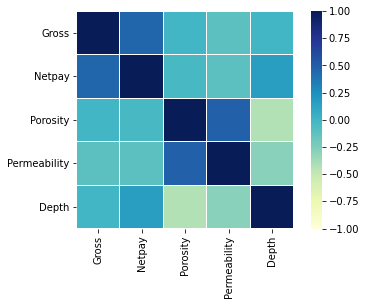

In [116]:
correl = pd.DataFrame(train[['Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth']]).corr()
sns.heatmap(correl, vmin = -1, vmax = 1, linewidths = 0.01, square = True, cmap="YlGnBu")
plt.show()

## Модели

In [117]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [118]:
LogReg = OneVsRestClassifier(LogisticRegression())
LogReg.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), LogReg.predict(np.array(X)))

0.889967637540453

In [119]:
LogReg = OneVsOneClassifier(LogisticRegression())
LogReg.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), LogReg.predict(np.array(X)))

0.8996763754045307

In [124]:
cv_results = cross_validate(OneVsOneClassifier(LogisticRegression()),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([0.04394412, 0.03439212, 0.03518128, 0.03382277, 0.03079128]),
 'score_time': array([0.00132155, 0.00146484, 0.00147367, 0.00129867, 0.00129652]),
 'test_score': array([0.80645161, 0.77419355, 0.83870968, 0.88709677, 0.86885246])}

In [125]:
LogRegCV = OneVsOneClassifier(LogisticRegressionCV(cv=5, max_iter=10000))
LogRegCV.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), LogRegCV.predict(np.array(X)))

0.889967637540453

In [126]:
cv_results = cross_validate(OneVsRestClassifier(LogisticRegressionCV(cv=4, max_iter=10000)),
                            np.array(X), np.array(y), cv=4)
cv_results

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


{'fit_time': array([3.08638096, 3.35613918, 3.20170617, 2.7652204 ]),
 'score_time': array([0.00081515, 0.00075769, 0.00079036, 0.00081229]),
 'test_score': array([0.80769231, 0.85714286, 0.88311688, 0.83116883])}

In [127]:
SVC = OneVsOneClassifier(LinearSVC(random_state=1))
SVC.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), SVC.predict(np.array(X)))

0.9255663430420712

In [128]:
cv_results = cross_validate(OneVsRestClassifier(LinearSVC(random_state=1)),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([0.02633309, 0.01624203, 0.01802301, 0.01627469, 0.01781106]),
 'score_time': array([0.00073957, 0.00072622, 0.00065827, 0.00061011, 0.00060487]),
 'test_score': array([0.83870968, 0.77419355, 0.85483871, 0.82258065, 0.78688525])}

In [129]:
lasso = OneVsOneClassifier(Lasso())
lasso.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), lasso.predict(np.array(X)))

0.6828478964401294

In [130]:
ridge = OneVsRestClassifier(Ridge())
ridge.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), ridge.predict(np.array(X)))

0.883495145631068

In [131]:
cv_results = cross_validate(OneVsRestClassifier(Ridge()),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([0.01512623, 0.01140404, 0.00648189, 0.00660706, 0.00630307]),
 'score_time': array([0.00060391, 0.0005486 , 0.00073051, 0.00075197, 0.00075674]),
 'test_score': array([0.83870968, 0.77419355, 0.80645161, 0.83870968, 0.83606557])}

In [29]:
tree_clf = DecisionTreeClassifier(max_depth=6)
tree_clf.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), tree_clf.predict(np.array(X)))

0.919093851132686

In [30]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=4, )
rf.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), rf.predict(np.array(X)))

0.8964401294498382

In [83]:
cv_results = cross_validate(OneVsOneClassifier(RandomForestClassifier(n_estimators=1000, max_depth=4, )),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([3.72779036, 3.75763917, 3.82141376, 3.7451241 , 3.74857068]),
 'score_time': array([0.44012594, 0.43299603, 0.43651605, 0.43164682, 0.43459749]),
 'test_score': array([0.82258065, 0.79032258, 0.77419355, 0.90322581, 0.81967213])}

In [32]:
gb = OneVsOneClassifier(GradientBoostingClassifier(max_depth=3))
gb.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), gb.predict(np.array(X)))

1.0

In [82]:
cv_results = cross_validate(OneVsOneClassifier(GradientBoostingClassifier(n_estimators=1000, max_depth=4, )),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([1.2692585 , 1.18836522, 1.17763519, 1.20549154, 1.1794064 ]),
 'score_time': array([0.00559664, 0.0054822 , 0.00520968, 0.00547123, 0.00543833]),
 'test_score': array([0.80645161, 0.83870968, 0.77419355, 0.85483871, 0.7704918 ])}

In [132]:
cv_results = cross_validate(OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100, 2), max_iter=1000)),
                            np.array(X), np.array(y), cv=5)
cv_results

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'fit_time': array([3.88203573, 4.56982899, 6.3056128 , 2.83256626, 5.0487535 ]),
 'score_time': array([0.00203943, 0.00195479, 0.00201678, 0.00194979, 0.00198483]),
 'test_score': array([0.91935484, 0.82258065, 0.80645161, 0.87096774, 0.78688525])}

In [133]:
cv_results = cross_validate(OneVsOneClassifier(MLPClassifier(hidden_layer_sizes=(256, 8), max_iter=10000)),
                            np.array(X), np.array(y), cv=5)
cv_results

{'fit_time': array([2.03489709, 6.23651004, 2.03022385, 2.36040878, 1.96126175]),
 'score_time': array([0.00513554, 0.0048573 , 0.00549603, 0.00492287, 0.00480437]),
 'test_score': array([0.88709677, 0.80645161, 0.83870968, 0.85483871, 0.78688525])}

In [134]:
MLP = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(256, 8), max_iter=5000))
MLP.fit(np.array(X), np.array(y))
accuracy_score(np.array(y), MLP.predict(np.array(X)))

1.0

In [ ]:
np.savetxt("prediction.csv", enc.inverse_transform(MLP.predict(X_test)).reshape(-1, 1), delimiter=",", fmt='%s') # Сохранить результаты 43
enc.inverse_transform(MLP.predict(X_test))

In [86]:
stack = StackingClassifier([('MLP', OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(256, 8), max_iter=5000))),
                            ('LR', OneVsOneClassifier(LogisticRegression())), 
                            ('RF', OneVsOneClassifier(RandomForestClassifier(n_estimators=1000, max_depth=4))), 
                            ('GB', OneVsOneClassifier(GradientBoostingClassifier(n_estimators=1000, max_depth=4)))],
                            final_estimator=LogisticRegression())

cv_results = cross_validate(stack,
                            np.array(X), np.array(y), cv=5)
cv_results

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to conver

{'fit_time': array([54.21546435, 44.76221037, 45.84784579, 47.30638885, 45.46372437]),
 'score_time': array([0.501369  , 0.49933386, 0.54116964, 0.53200793, 0.53167343]),
 'test_score': array([0.82258065, 0.82258065, 0.85483871, 0.83870968, 0.85245902])}

In [89]:
stack.fit(np.array(X), np.array(y))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


StackingClassifier(cv=None,
                   estimators=[('MLP',
                                OneVsRestClassifier(estimator=MLPClassifier(activation='relu',
                                                                            alpha=0.0001,
                                                                            batch_size='auto',
                                                                            beta_1=0.9,
                                                                            beta_2=0.999,
                                                                            early_stopping=False,
                                                                            epsilon=1e-08,
                                                                            hidden_layer_sizes=(256,
                                                                                                8),
                                                                            learning_

In [ ]:
np.savetxt("prediction1.csv", enc.inverse_transform(stack.predict(X_test)).reshape(-1, 1), delimiter=",", fmt='%s') # Сохранить результаты 43
enc.inverse_transform(stack.predict(X_test)).reshape(-1, 1)

In [92]:
np.savetxt("prediction2.csv", enc.inverse_transform(LogRegCV.predict(X_test)).reshape(-1, 1), delimiter=",", fmt='%s') # 42
enc.inverse_transform(LogRegCV.predict(X_test))

array(['ONSHORE', 'ONSHORE', 'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'OFFSHORE', 'OFFSHORE',
       'OFFSHORE', 'ONSHORE', 'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE',
       'OFFSHORE', 'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'OFFSHORE', 'OFFSHORE', 'OFFSHORE', 'ONSHORE', 'OFFSHORE',
       'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'OFFSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'OFFSHORE', 'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE', 'ONSHORE',
       'ONSHORE', 'ONSHORE', 'OFFSHORE', 'ONSHORE', 'ONSH

# Задание 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Я профи/problem_2"

Mounted at /content/drive
/content/drive/MyDrive/Я профи/problem_2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
formula_train = pd.read_csv('formula_train.csv')
target = train['critical_temperature']
train.drop('critical_temperature', axis=1, inplace=True)
test = pd.read_csv('test.csv')
formula_test = pd.read_csv('formula_test.csv')

In [4]:
train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,...,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81
0,4,95.950150,87.221940,89.534122,81.423258,1.317590,1.301059,96.1190,20.285800,36.105357,34.833271,740.625,786.620000,726.788285,771.273911,1.367745,1.202333,399.3,307.450000,142.347627,149.963748,169.75,156.400000,164.442987,150.821660,1.355290,1.327938,117,29.000000,42.180416,43.345588,7803.7500,6938.8000,7354.256010,6686.502371,1.325027,1.325720,7126.000,1313.400000,2816.060402,...,62.7500,57.540000,51.870923,47.246119,1.238413,1.159644,85.60,26.640000,31.960640,29.887027,19.1250,19.650000,17.385762,17.932694,1.299408,1.140380,18.400,9.220000,7.772508,7.827675,65.750000,58.500000,50.754738,48.531069,1.191039,1.203416,106.00000,20.900000,38.873995,30.483602,4.25,4.10,4.053600,3.944244,1.339718,1.245504,3,1.400000,1.299038,1.135782
1,5,83.244760,59.224400,59.506081,36.126175,1.311510,1.372050,192.9810,25.192187,67.233835,64.196304,779.880,1005.866667,740.399333,945.371396,1.553219,1.019202,764.1,661.026667,276.063148,333.238432,149.80,106.133333,133.425311,86.457339,1.519537,1.573185,171,16.266667,58.608532,66.319295,4584.2858,2953.4288,874.164786,64.622881,1.161774,1.099512,9778.571,1303.237867,4004.273231,...,73.1000,105.475333,33.148783,68.547287,1.200886,0.827671,138.63,75.742000,57.645673,52.670782,8.1524,4.954400,4.646433,1.321875,1.392937,1.395814,12.878,1.628267,4.361026,5.253410,128.605316,72.414176,14.287643,0.969156,0.871976,0.777323,399.97342,53.319157,154.008028,137.579265,2.60,2.40,2.402249,2.259897,1.519383,1.365077,3,0.933333,1.200000,1.019804
2,2,23.035850,26.647510,21.192566,25.010514,0.614232,0.435817,18.0583,18.243490,9.029150,8.275353,1200.250,1119.750000,1183.257580,1105.792837,0.679023,0.661811,402.5,278.850000,201.250000,184.448672,71.50,77.700000,69.799713,76.228941,0.669462,0.522077,31,44.100000,15.500000,14.205985,980.6255,1372.3753,49.517270,215.653466,0.005331,0.002517,1958.749,1371.624700,979.374500,...,105.0000,143.600000,41.385384,77.950376,0.169455,0.089179,193.00,138.500000,96.500000,88.443711,1.0450,1.319000,0.789177,1.080247,0.459434,0.283338,1.370,1.103000,0.685000,0.627813,0.115415,0.151249,0.072768,0.110120,0.350471,0.202131,0.17917,0.135751,0.089585,0.082106,4.50,5.10,4.242641,4.873514,0.636514,0.465999,3,3.300000,1.500000,1.374773
3,4,81.756699,79.833804,76.282833,75.275775,1.312596,1.149324,81.4820,28.789976,32.890369,29.969284,741.475,782.600000,723.246140,763.358485,1.362746,1.059188,443.7,363.318000,157.803998,163.153443,168.75,158.520000,161.714287,151.499174,1.342444,1.166582,139,56.240000,51.329207,50.807181,6502.7500,6162.9200,6126.394078,5912.543550,1.332169,1.068492,5390.000,2814.120000,2072.768363,...,44.3375,42.730000,34.258466,31.894684,1.166445,0.803499,64.05,30.496000,28.471814,30.780312,16.4250,18.248000,14.919043,16.404170,1.293519,0.946275,19.700,10.756000,7.159740,8.021377,61.750000,55.620000,51.637761,49.174596,1.244889,0.997395,82.00000,28.020000,30.873735,23.297974,3.50,3.62,3.309751,3.413039,1.333736,1.019322,3,1.920000,1.118034,1.198165
4,2,67.485250,69.699016,57.442709,59.574464,0.548263,0.521345,70.8405,39.638078,35.420250,35.351002,859.250,850.515625,847.809236,839.158377,0.679862,0.688021,279.5,86.046875,139.750000,139.476784,130.00,132.687500,122.682517,125.346336,0.637399,0.

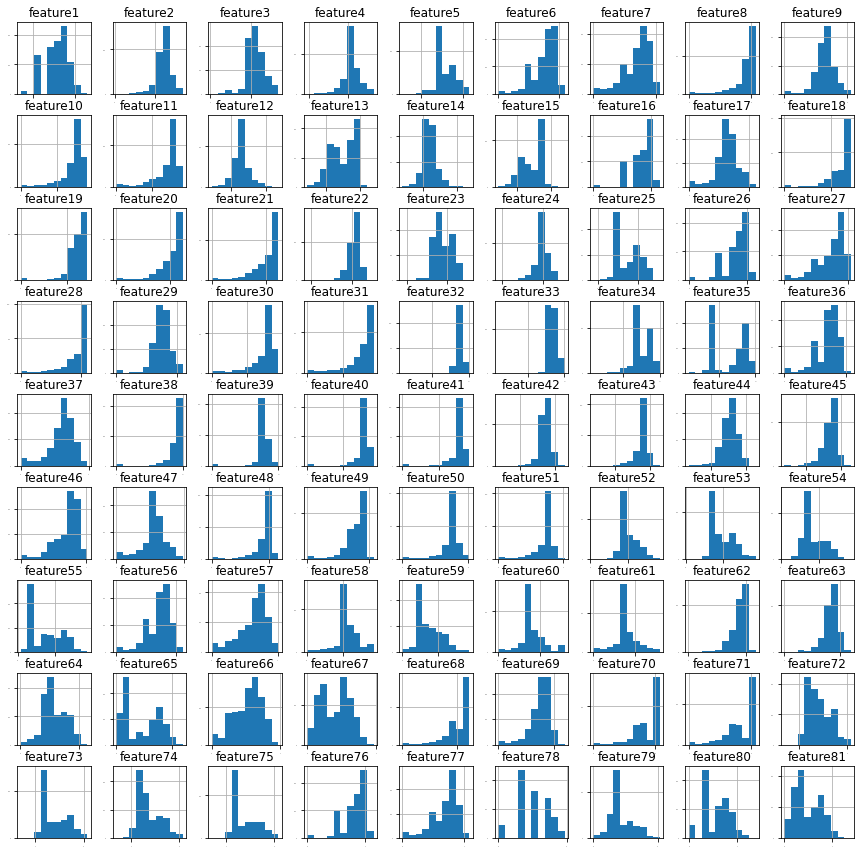

In [5]:
np.log1p(train).hist(xlabelsize=.01, ylabelsize=0.01, figsize=(15, 15), label = None)
plt.show()

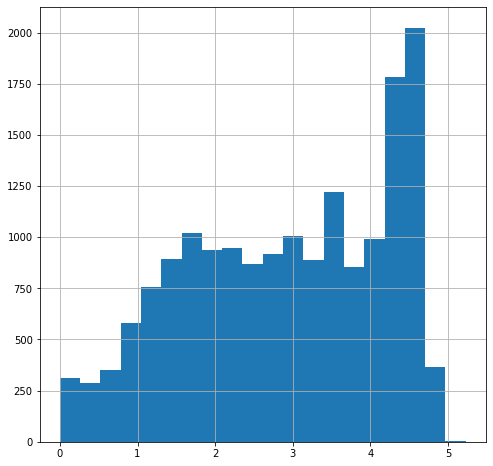

In [6]:
np.log1p(target).hist(figsize=(8, 8), bins=20)
plt.show()

In [7]:
formula_train.head()

,H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al,Si,P,S,Cl,Ar,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Br,Kr,Rb,Sr,Y,Zr,...,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Eu1Fe1.5Ru0.5As2
1,0.0,0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,Bi2Sr2Ca1Cu2O8
2,0.0,0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,N0.3S0.7
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9,0.1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba1Fe1.9Co0.1As2
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Rh17S15


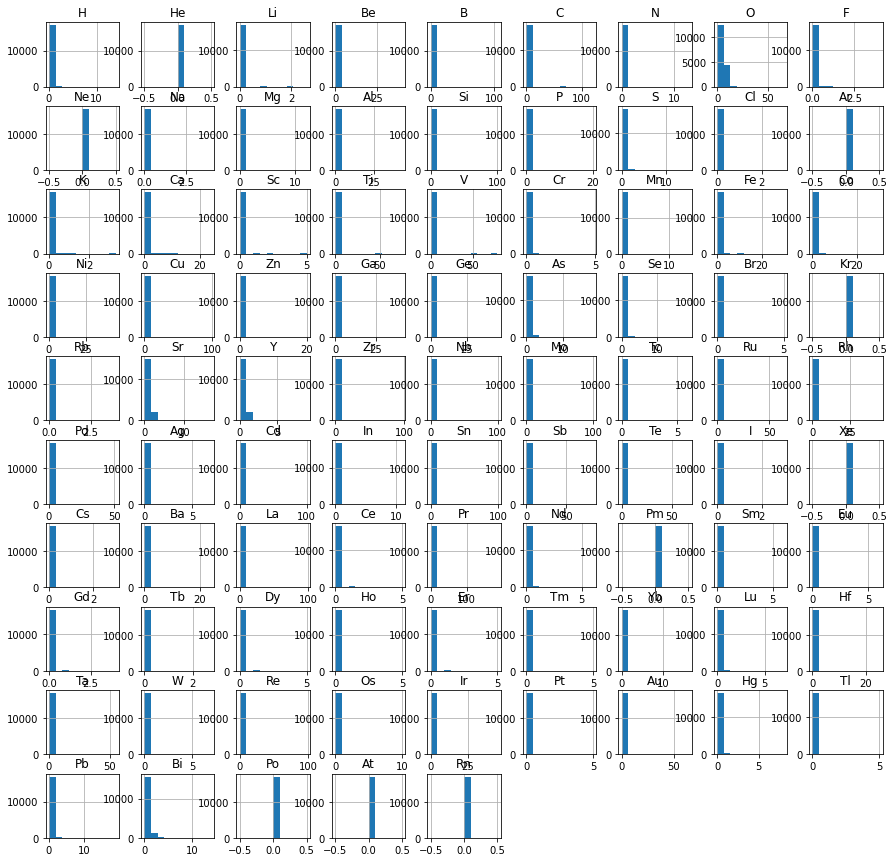

In [8]:
formula_train.hist(figsize=(15, 15), label = None)
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler # , PolynomialFeatures

scaler_X = StandardScaler()
scaler_X.fit(np.log1p(train))
print(scaler_X.mean_)
print(scaler_X.scale_)

target_mean = np.mean(np.log1p(target))
target_std = np.std(np.log1p(target))
print(target_mean)
print(target_std)

[1.58811104 4.42221299 4.21157013 4.19422927 3.93482687 0.75623712
 0.70299687 4.51906994 3.27033887 3.62371152 3.52833713 6.64055379
 6.75550698 6.5989052  6.71483957 0.81640223 0.63970852 5.98615775
 5.96375899 5.07725205 5.03456241 5.06069494 4.88981297 4.96875286
 4.76360103 0.80291463 0.73524248 4.66080454 3.73165518 3.74722117
 3.71712115 8.63265363 8.42861809 7.56339162 6.49181969 0.7129975
 0.60202562 8.79750404 7.67266052 7.89272112 7.83134714 4.28586234
 4.45263671 3.87554692 4.1709767  0.71116692 0.55705806 4.60368768
 3.90314527 3.75246591 3.6386123  2.54563271 2.39214079 2.13263149
 1.84031155 0.72056594 0.62841535 2.81408238 1.8145047  1.97451104
 1.93931034 4.37735522 4.24440879 2.94718902 2.24147597 0.52801495
 0.41082392 5.1129038  3.83856714 4.24846738 4.16042472 1.4066812
 1.38658823 1.37104051 1.36288082 0.81382289 0.69913164 1.02239747
 0.84520447 0.5747373  0.48014283]
[0.30415604 0.37687174 0.44011352 0.43280007 0.54221316 0.18878841
 0.21762705 0.93440331 0.7824

In [24]:
X_f = np.array(formula_train.drop('material', axis=1)) 
X_f = X_f / np.sum(X_f, axis = 1).reshape(-1, 1) # Доля веществ в каждой формуле
X_f_test = np.array(formula_test.drop('material', axis=1))
X_f_test = X_f_test / np.sum(X_f_test, axis = 1).reshape(-1, 1)

In [30]:
X = scaler_X.transform(np.log1p(train))
X = np.concatenate([X, X_f], axis=1)
X_test = scaler_X.transform(np.log1p(test))
X_test = np.concatenate([X_test, X_f_test], axis=1)

y = (np.array(np.log1p(target)) - target_mean) / target_std

In [38]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_validate

In [65]:
MLP = MLPRegressor(hidden_layer_sizes=(512, 8), max_iter=5000) # 512 x 8 - 44 балла # 256 x 8 - 42 балла
MLP.fit(np.array(X), np.array(y))
r2_score(np.array(y), MLP.predict(np.array(X)))

0.9409372464021966

In [58]:
cv_results = cross_validate(MLPRegressor(hidden_layer_sizes=(512, 8), max_iter=5000),
                            np.array(X), np.array(y), cv=5, scoring='r2')
cv_results

{'fit_time': array([ 72.24204564,  73.64994764, 112.85246968,  78.39303899,
        123.4566586 ]),
 'score_time': array([0.04427004, 0.0445981 , 0.04312229, 0.04405951, 0.04283643]),
 'test_score': array([0.89498436, 0.90223442, 0.9129095 , 0.89483015, 0.89517175])}

In [66]:
# Сохранить
# np.expm1(MLP.predict(X_test) * target_std + target_mean).tofile('answer.csv',sep=',')
np.savetxt("answer.csv", np.expm1(MLP.predict(X_test) * target_std + target_mean), delimiter=",")
np.expm1(MLP.predict(X_test) * target_std + target_mean)

array([58.4298215 ,  3.16808875, 17.68414671, ..., 33.28534617,
       28.43690084,  9.26240308])

In [39]:
cv_results = cross_validate(GradientBoostingRegressor(),
                            np.array(X), np.array(y), cv=5, scoring='r2')
cv_results

{'fit_time': array([35.13125348, 35.36094046, 35.60794115, 34.8676281 , 35.07302022]),
 'score_time': array([0.01305938, 0.00965881, 0.01037884, 0.010988  , 0.01207566]),
 'test_score': array([0.86426744, 0.85883166, 0.86116103, 0.85193812, 0.85700516])}

In [46]:
cv_results = cross_validate(RandomForestRegressor(n_estimators=100, max_depth=3),
                            np.array(X), np.array(y), cv=5, scoring='r2')
cv_results

{'fit_time': array([21.56461525, 21.58727145, 21.61468172, 21.95291662, 21.5813489 ]),
 'score_time': array([0.02260232, 0.02566838, 0.02283669, 0.02186966, 0.02815104]),
 'test_score': array([0.7507686 , 0.74129504, 0.74064026, 0.73083827, 0.74445758])}

### Catboost

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from catboost import CatBoostRegressor, Pool, cv

In [ ]:
model = CatBoostClassifier(
    custom_loss=['R2'],
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);